# Анализ пользовательского поведения в мобильном приложении

**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 

   - EventName — название события;
   - DeviceIDHash — уникальный идентификатор пользователя;
   - EventTimestamp — время события;
   - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Откройте файл с данными и изучите общую информацию

In [3]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st

In [4]:
data = pd.read_csv('logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


##  Подготовьте данные

### Замените названия столбцов на удобные для вас

In [5]:
data.columns = ['event_name', 'user_id', 'event_time', 'exp_id']

### Проверьте пропуски и типы данных. Откорректируйте, если нужно

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Переведем дату в нужный формат.

In [7]:
data.event_time = pd.to_datetime(data.event_time, unit = 's')

In [8]:
#проверим наличие дубликатов
data.duplicated().sum()

413

In [9]:
#удалим дубликаты 
data = data.drop_duplicates()

### Добавьте столбец даты и времени, а также отдельный столбец дат

In [10]:
data.head(2)

,event_name,user_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


In [11]:
#добавим дополнительный столбец с датой
data['date'] = data.event_time.dt.date
data.head()

,event_name,user_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим наличие пропусков. 

In [12]:
data.isnull().sum()

event_name    0
user_id       0
event_time    0
exp_id        0
date          0
dtype: int64

**Вывод:** Привели дату в нужный формат, нашли 413 дубликатов и удалили их, добавили новый столбец с датой "date", заменили названия столбцов на удобный, пропуски не обнаружили.

##  Изучите и проверьте данные

### Сколько всего событий в логе?

In [13]:
print('В логе всего', len(data['event_name']), 'событий')

В логе всего 243713 событий


In [14]:
print('В логе всего', len(data['event_name'].value_counts()), 'видов событий')

В логе всего 5 видов событий


### Сколько всего пользователей в логе?

In [15]:
print('В логе всего', len(data['user_id'].value_counts()), 'пользователь')

В логе всего 7551 пользователь


### Сколько в среднем событий приходится на пользователя?

In [16]:
df = data.pivot_table(index='user_id',values='event_name',aggfunc='count')
print('В среднем на пользователя приходится', round(df['event_name'].mean(), 1), 'события')

В среднем на пользователя приходится 32.3 события


### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого  — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [17]:
print('Минимальная дата', data['date'].min())

Минимальная дата 2019-07-25


In [18]:
print('Максимальная дата', data['date'].max())

Максимальная дата 2019-08-07


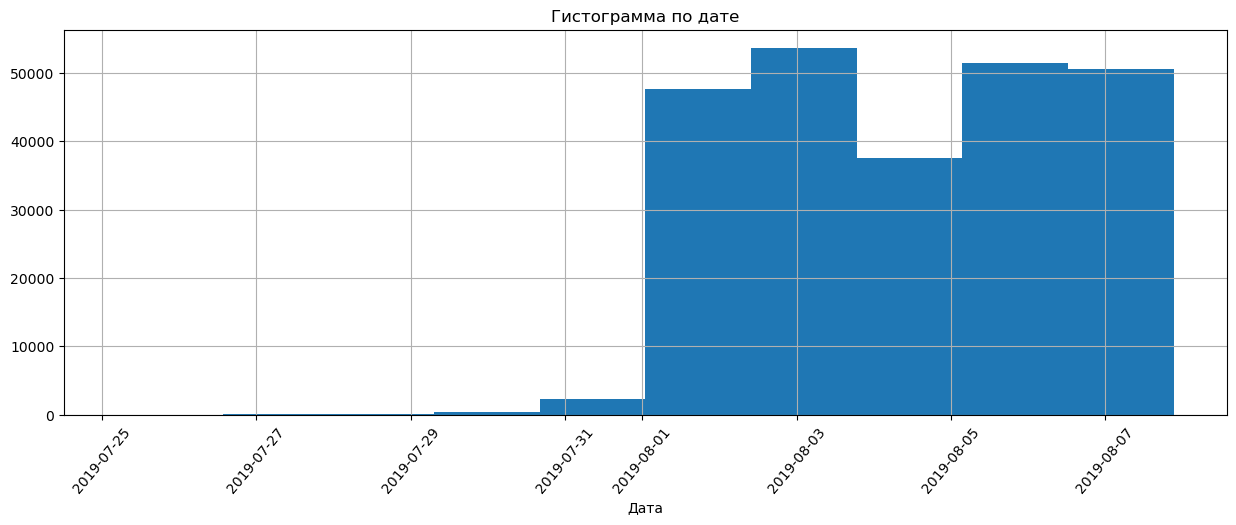

In [19]:
plt.figure(figsize=(15,5))
plt.grid()
plt.title('Гистограмма по дате')
plt.xlabel('Дата')
plt.xticks(rotation=50) 
data['event_time'].hist();

Мы видим, что до 1.08.2019 было очень мало данных, скорее всего данные за этот период неполные. 

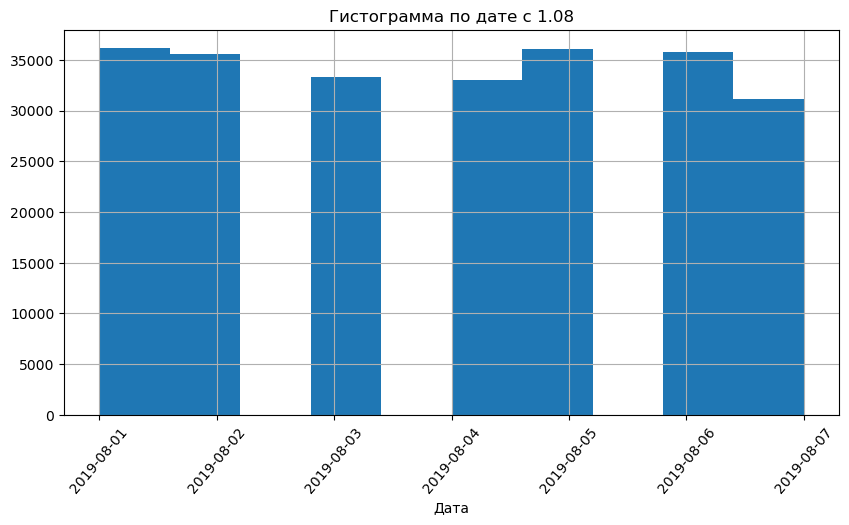

In [20]:
data['date'] = pd.to_datetime(data['date'])
data_new = data.query('date > "2019-07-31"')
plt.figure(figsize=(10,5))
plt.grid()
plt.title('Гистограмма по дате c 1.08')
plt.xlabel('Дата')
plt.xticks(rotation=50) 
data_new['date'].hist();

Я распологаю данными с 1.08.2019 по 7.08.2019.

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [21]:
len(data['event_name'])

243713

In [22]:
data_new = data.query('date >= "2019-08-01"')
print('Потеряли', len(data['event_name']) - len(data_new['event_name']), 'событий')
print('Доля событий',round(100-len(data_new['event_name'])/len(data['event_name'])*100,2), '%')

Потеряли 2826 событий
Доля событий 1.16 %


In [23]:
print('Потеряли', len(data['user_id'].unique()) - len(data_new['user_id'].unique()), 'пользователей')
print('Доля пользователей',round(100-len(data_new['user_id'].unique())/len(data['user_id'].unique())*100,2), '%')

Потеряли 17 пользователей
Доля пользователей 0.23 %


### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [26]:
data.head()

,event_name,user_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [27]:
data['exp_id'].value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

Проверили сколько событий в экспериментальных группах.

In [28]:
data.groupby('exp_id')['user_id'].nunique()

exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

И количество пользователей в каждой экспериментальной группе.

In [29]:
data.groupby('user_id').agg({'exp_id':'nunique'}).query('exp_id>1').count()   

exp_id    0
dtype: int64

Пересечений поользователей не выявлено.

## Изучите воронку событий


### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [31]:
data_event = data['event_name'].value_counts().sort_values(ascending=False).to_frame().reset_index()
data_event

,index,event_name
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Событие "MainScreenAppear" встречается в логах чаще всего, реже всего событие Tutorial.

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [32]:
data_id = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
data_id['percent'] = round(data_id['user_id']/data['user_id'].nunique(),4)*100
data_id

,event_name,user_id,percent
0,MainScreenAppear,7439,98.52
1,OffersScreenAppear,4613,61.09
2,CartScreenAppear,3749,49.65
3,PaymentScreenSuccessful,3547,46.97
4,Tutorial,847,11.22


98.52% пользователей совершили событие - MainScreenAppear, до события Tutorial дошло всего 11.22% пользователей

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Думаю, что событие Tutorial не нужно учитывать при расчете воронки, т.к. оно в воронку в приницпе не входит. Скорее всего это просто обучение.

Сначала пользователи перходят на главную страницу сайта MainScreenAppear, далее на страницу с предложением OffersScreenAppear, после добавляют товар в корзину CartScreenAppear и происходит оплата PaymentScreenSuccessful.

Предлагаю шаг "Tutorial" удалить, т.к. он при анализе не нужен.

In [33]:
data_id.drop([4], axis=0, inplace=True)
data_id

,event_name,user_id,percent
0,MainScreenAppear,7439,98.52
1,OffersScreenAppear,4613,61.09
2,CartScreenAppear,3749,49.65
3,PaymentScreenSuccessful,3547,46.97


### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [34]:
data_id['proportion'] = 100
for i in range(1, 4):
    data_id.loc[i, 'proportion'] = round(data_id.loc[i, 'user_id'] / (data_id.loc[i-1, 'user_id']) *100,2)

data_id

,event_name,user_id,percent,proportion
0,MainScreenAppear,7439,98.52,100.00
1,OffersScreenAppear,4613,61.09,62.01
2,CartScreenAppear,3749,49.65,81.27
3,PaymentScreenSuccessful,3547,46.97,94.61


### На каком шаге теряете больше всего пользователей?

Большее количество пользователей отваливается на шаге "OffersScreenAppear", мы теряем около 38% пользователей, которые достигли шага "MainScreenAppear". Меьше всего отваливается от оплаты, чуть больше 5%.

### Какая доля пользователей доходит от первого события до оплаты?

In [35]:
data_id

,event_name,user_id,percent,proportion
0,MainScreenAppear,7439,98.52,100.00
1,OffersScreenAppear,4613,61.09,62.01
2,CartScreenAppear,3749,49.65,81.27
3,PaymentScreenSuccessful,3547,46.97,94.61


In [36]:
round(data_id['percent'].iloc[1]/data_id['percent'].iloc[0] * 100,2)

62.01

С первого шага "MainScreenAppear" и до оплаты "PaymentScreenSuccessful" доходит 47,68% пользователей.

In [37]:
import plotly.express as px
fig = px.funnel(data_id, x='proportion', y='event_name',  title='Воронка продаж')
fig.show()

In [38]:
import plotly.express as px
fig = px.funnel(data_id, x='percent', y='event_name',  title='Воронка продаж')
fig.show()

## Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [39]:
data_new.groupby('exp_id')['user_id'].nunique().to_frame()

,user_id
exp_id,
246,2484
247,2513
248,2537


In [40]:
#сформируем сводную таблицу 
data_test = data_new.pivot_table(index='exp_id',columns = 'event_name', values='user_id',aggfunc='nunique')

data_test.reset_index()


event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


Мы видим, что в каждой экспериментальной группе примерно одинаковое количество пользователей. Также по событиям пользователи распределяются достаточно равномерно.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Сформируем гипотезы:

**Нулевая гипотеза:** Доля пользователей, совершивших событие, одинаковая.

**Альтернативная гипотеза:** Между долями пользователей, совершивших событие, есть значимая статистическая разница.

In [41]:
def test(df, exp_id, alpha):
    
    users = [df.query('exp_id == @exp')['user_id'].nunique() for exp in exp_id]
   
    for event in df.event_name.unique():
        events = [df.query('exp_id == %d and event_name == "%s"' % (exp, event))['user_id'].nunique() for exp in exp_id]
        
        p1 = events[0] / users[0] 
        p2 = events[1] / users[1] 
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]))
        
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие:', event)
        print('p-значение: {p_value:}'.format(p_value=p_value))
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями пользователей, совершивших событие, есть значимая статистическая разница.')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы')
            
        print('')    

Проверим группы 246 и 247. 

In [42]:
test(data, [246, 247], 0.1)

Событие: MainScreenAppear
p-значение: 0.5856639791209877
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.10902546202332886
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.19817540651836918
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.3233225048227193
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.8756574258016974
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



Статистически значимых различий между группами нет, пользователи распределились равномерно.

In [43]:
test(data, [246, 248], 0.1)

Событие: MainScreenAppear
p-значение: 0.39774960182882513
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.23403912852637143
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.10534150642722295
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.2531656758489338
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.8962914725257976
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



In [44]:
test(data, [247, 248], 0.1)

Событие: MainScreenAppear
p-значение: 0.7632160970326178
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.6763830984465451
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.7406094633808076
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.878057445632423
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.773300249936147
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



**Вывод:** Мы не смогли отвергнуть нулевую гипотеза, различия по всем событиям и между группами не значимы.

Далее проверим различия между объединенной группой (246+247) и группой 248, которая с измененным шрифтом. 
Для этого нам нужно объединить 2 группы, столбец exp_id со значением 246 изменю на 247.

In [45]:
data_group = data.copy()
data_group.loc[(data_group.exp_id == 246), ('exp_id')] = 247
data_group['exp_id'].unique()

array([247, 248])

In [46]:
test(data_group, [247, 248], 0.1)

Событие: MainScreenAppear
p-значение: 0.5067126962216841
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.6578429353593096
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.2609811882648243
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.4555404043137232
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.8086866211802637
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



Различия также статистически не значимы.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [47]:
test(data, [246, 247], 0.05)

Событие: MainScreenAppear
p-значение: 0.5856639791209877
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.10902546202332886
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.19817540651836918
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.3233225048227193
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.8756574258016974
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



In [48]:
test(data, [246, 248], 0.05)

Событие: MainScreenAppear
p-значение: 0.39774960182882513
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.23403912852637143
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.10534150642722295
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.2531656758489338
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.8962914725257976
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



In [49]:
test(data, [247, 248], 0.05)

Событие: MainScreenAppear
p-значение: 0.7632160970326178
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.6763830984465451
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.7406094633808076
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.878057445632423
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.773300249936147
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



In [50]:
test(data_group, [247, 248], 0.05)

Событие: MainScreenAppear
p-значение: 0.5067126962216841
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.6578429353593096
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: CartScreenAppear
p-значение: 0.2609811882648243
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.4555404043137232
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы

Событие: Tutorial
p-значение: 0.8086866211802637
Не получилось отвергнуть нулевую гипотезу: различия между долями статистически не значимы



Я проверила гипотезы с разными уровнями значимости. Во всех нулевую гипотезу отвергнуть не получилось, т.е. можно сделать вывод о том, что доли не имеют статистической разницы, значит шрифт никак не повлиял на пользователей. 

**Вывод:**
- Я проверила данные с логами, нашла всего 413 дубликатов, посчитала нужным их удалить, заменила названия стобцов на удобные для анализа, одинаковых пользователей в экспериментальных группах не нашла, пропусков также не было;
- Изучила данные, в логах 243713 событи, всего 5 видов событий, 4 из них формируют воронку. В логах всего 7551 пользователя, в среднем на пользователя приходится 32 события.
- Я распологаю данными с 2019-07-25 по 2019-08-07. Но с 2019-08-01 было очень мало данных, скорее всего до этого времени были неполные данных, поэтому я их отбросила. 

Мы имеем воронку событий: 
* MainScreenAppear (главная страница сайта)
* OffersScreenAppear (страница с предложением, возможно, каточка товара)
* CartScreenAppear (страница корзины)
* PaymentScreenSuccessful (успешное оформление заказа)

Также мы имеем событие Tutorial (обучение), но я считаю, что оно вне воронки. 

Всего 98.52% пользователей попали на MainScreenAppear, большее количество пользователей отваливается на шаге "OffersScreenAppear", мы теряем около 38% пользователей, которые достигли шага "MainScreenAppear". Меньше всего отваливается от оплаты, чуть больше 5%. С первого шага "MainScreenAppear" и до оплаты "PaymentScreenSuccessful" доходит 47,68% пользователей.

- Провела А/А/В тестирование. Я выявила, что доли пользователей одинаковые, в тесте использовала разные уровни значимости, но p-value всегда был значительно больше 0.05. Могу сделать вывод, что изменение шрифта никак не повлияло на действия пользователей. Большая часть пользователей отваливается на событии MainScreenAppear и не переходят на OffersScreenAppear, я бы предложила скорее поработать с кнопкой перехода в корзину, либо же самим оформлением карточки.  

События на пользователя в каждой из групп распределены неравномерно, в группе А - 7 событий, в группе В - 6 событий. Также во время проведения теста проводилось два мероприятия, но т.к. мы исследуем только пользователей из Европы, то только Christmas&New Year Promo могло повлиять на пользователей.

Распределение событий по дням тоже неравномерное, мы видим, что в группе А после 12.12 был рост количества событий, в группе В рост был менее выражен, также в группе А наблюдается всплеск 21.12, в группе В он был совсем небольшой

